Analysis of influence of single-neuron excitability changes on network population activity.

In [1]:
%reset -f
%autosave 60

Autosaving every 60 seconds


In [2]:
%matplotlib inline
from copy import deepcopy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx

from aux import Generic, GenericFlexible
from ntwk import LIFNtwk
from disp import raster, set_font_size

# Settings

In [3]:
SEED = 1
N = 100
E_L_1 = -0.05

GAMMA = 1  # for SF ntwk
Q = 0.1  # for ER ntwk

W_E_RCR = 0.01
W_E_UP = 0.01

FRQ_UP_UNC = 600
FRQ_UP_SF = 400
FRQ_UP_ER = 400
FRQ_UP_SW = 400

DT = 0.0005
T_M = 0.05
E_L = -0.068
V_TH = -0.036
V_RESET = -0.068
T_R = 0.002
E_E = 0
T_E = 0.002

STM_OFF = 10
DUR = 11

T_START = 0.5
T_END = 10
T_BIN_SIZE = 0.01

# Basic graph types

## Unconnected

### Unconnected LIF ntwk

In [4]:
def unc_ntwk(P, STORE=None):
    """Make a new LIF ntwk with no recurrent connectivity."""
    # make upstream weight matrix
    ws_up = {'E': P.w_e_up * np.eye(P.n)}
    
    c_rcr = np.zeros((P.n, P.n), dtype=bool)
    
    # remake graph
    g = nx.from_numpy_matrix(c_rcr.T, create_using=nx.DiGraph())
    
    # set weights
    ws_rcr = {'E': P.w_e_rcr * c_rcr}
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=np.repeat(P.t_m, P.n),
        e_l=np.repeat(P.e_l, P.n),
        v_th=np.repeat(P.v_th, P.n),
        v_reset=np.repeat(P.v_reset, P.n),
        t_r=np.repeat(P.t_r, P.n),
        es_syn={'E': P.e_e},
        ts_syn={'E': P.t_e},
        ws_rcr=ws_rcr,
        ws_up=ws_up)
    
    STORE.g = g
    STORE.c_rcr = c_rcr.copy()
    STORE.ws_rcr = ws_rcr.copy()
    
    return ntwk, STORE

## Scale-free graph

In [5]:
def directed_power_law_adj(n, gamma, seed):
    """
    Construct an adjacency matrix with equal but uncorrelated power-law
    in- and out-degree distributions.
    """
    deg_possible = np.arange(n, dtype=float)
    
    # get normalized power-law probability over deg_possible
    p_unnormed = (deg_possible + 1) ** (-gamma)
    p_normed = p_unnormed / np.sum(p_unnormed)
    
    # sample in-deg from power-law distribution
    np.random.seed(seed)
    in_deg = np.random.choice(deg_possible.astype(int), n, replace=True, p=p_normed)
    
    # shuffle out-deg to break corr. with in-deg
    out_deg = in_deg[np.random.permutation(n)]
    
    g = nx.directed_configuration_model(in_deg, out_deg, create_using=nx.DiGraph(), seed=seed)
    
    adj = np.array(nx.adjacency_matrix(g, weight=None).T.todense())
    np.fill_diagonal(adj, 0)
    
    return adj.astype(bool)

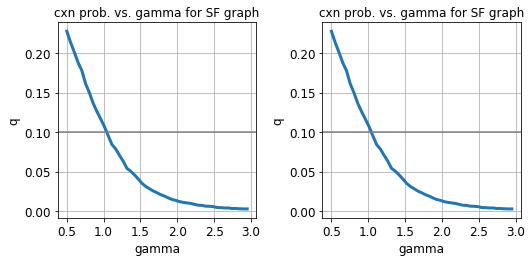

In [6]:
gammas = np.linspace(0.5, 3)[:-1]
qs = np.nan * np.zeros(gammas.shape)

for ctr, gamma in enumerate(gammas):
    
    # get cxn prob
    c_rcr = directed_power_law_adj(N, gamma, SEED)
    q = c_rcr.sum() / (N*(N-1))
    
    qs[ctr] = q
    
fig, axs = plt.subplots(1, 2, figsize=(7.5, 3.75), tight_layout=True)

for ax in axs:
    ax.plot(gammas, qs, lw=3)
    ax.axhline(.1, color='gray')
    ax.set_xlabel('gamma')
    ax.set_ylabel('q')
    ax.set_title('cxn prob. vs. gamma for SF graph')
    
    ax.grid()

    set_font_size(ax, 12)

### Scale-free LIF ntwk

In [7]:
def sf_ntwk(P, STORE=None):
    """Make a new LIF ntwk with scale-free connectivity."""
    # make upstream weight matrix
    ws_up = {'E': P.w_e_up * np.eye(P.n)}
    
    c_rcr = directed_power_law_adj(P.n, P.gamma, P.seed)
    
    # remake graph
    g = nx.from_numpy_matrix(c_rcr.T, create_using=nx.DiGraph())
    
    # set weights
    ws_rcr = {'E': P.w_e_rcr * c_rcr}
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=np.repeat(P.t_m, P.n),
        e_l=np.repeat(P.e_l, P.n),
        v_th=np.repeat(P.v_th, P.n),
        v_reset=np.repeat(P.v_reset, P.n),
        t_r=np.repeat(P.t_r, P.n),
        es_syn={'E': P.e_e},
        ts_syn={'E': P.t_e},
        ws_rcr=ws_rcr,
        ws_up=ws_up)
    
    STORE.g = g
    STORE.c_rcr = c_rcr.copy()
    STORE.ws_rcr = ws_rcr.copy()
    
    return ntwk, STORE

## Erdos-Renyi graph

### Erdos-Renyi LIF ntwk

In [8]:
def er_ntwk(P, STORE=None):
    """Make a new LIF ntwk with Erdos-Renyi connectivity."""
    # make upstream weight matrix
    ws_up = {'E': P.w_e_up * np.eye(P.n)}
    
    c_rcr = np.random.rand(P.n, P.n) < P.q
    
    # remake graph
    g = nx.from_numpy_matrix(c_rcr.T, create_using=nx.DiGraph())
    
    # set weights
    ws_rcr = {'E': P.w_e_rcr * c_rcr}
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=np.repeat(P.t_m, P.n),
        e_l=np.repeat(P.e_l, P.n),
        v_th=np.repeat(P.v_th, P.n),
        v_reset=np.repeat(P.v_reset, P.n),
        t_r=np.repeat(P.t_r, P.n),
        es_syn={'E': P.e_e},
        ts_syn={'E': P.t_e},
        ws_rcr=ws_rcr,
        ws_up=ws_up)
    
    STORE.g = g
    STORE.c_rcr = c_rcr.copy()
    STORE.ws_rcr = ws_rcr.copy()
    
    return ntwk, STORE

## Small-world graph

In [9]:
def sw_adj(n, k, p, seed):
    """
    Construct an adjacency matrix for a small-world network.
    """
    g = nx.watts_strogatz_graph(n, k, p, seed)
    adj = np.array(nx.adjacency_matrix(g, weight=None).T.todense())
    
    return adj

### Small-world LIF ntwk

In [10]:
def sw_ntwk(P, STORE=None):
    """Make a new LIF ntwk with small-world connectivity."""
    
    ws_up = {'E': P.w_e_up * np.eye(P.n)}
    
    c_rcr = sw_adj(P.n, P.k, P.p, P.seed)
    
    # remake graph
    g = nx.from_numpy_matrix(c_rcr.T, create_using=nx.DiGraph())
    
    # set weights
    ws_rcr = {'E': P.w_e_rcr * c_rcr}
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=np.repeat(P.t_m, P.n),
        e_l=np.repeat(P.e_l, P.n),
        v_th=np.repeat(P.v_th, P.n),
        v_reset=np.repeat(P.v_reset, P.n),
        t_r=np.repeat(P.t_r, P.n),
        es_syn={'E': P.e_e},
        ts_syn={'E': P.t_e},
        ws_rcr=ws_rcr,
        ws_up=ws_up)
    
    STORE.g = g
    STORE.c_rcr = c_rcr.copy()
    STORE.ws_rcr = ws_rcr.copy()
    
    return ntwk, STORE

# Param identification

## Function to drive ntwk with random input spks

In [11]:
def run(ntwk, P, STORE=None):
    """Construct SF ntwk and run smln."""
    
    # make noisy input
    np.random.seed(P.seed)
    t = np.arange(0, P.dur, P.dt)
    spks_up = np.random.poisson(P.frq_up * P.dt, (len(t), P.n))
    spks_up[t >= P.stm_off] = 0
    
    # run ntwk
    rsp = ntwk.run(spks_up, P.dt)
    
    STORE.spks_up = spks_up.copy()
    
    return rsp, STORE

## Raster/firing/correlation/degree plotting function

In [12]:
def rfcd_plot(make_ntwk, P, STORE, STORE_UNC=None):
    """
    Show raster plot, firing rate, correlation, and degree distributions.
    """
    # make ntwk and run smln
    ntwk = make_ntwk(P, STORE)[0]
    rsp = run(ntwk, P, STORE)[0]

    # make plots
    gs = gridspec.GridSpec(4, 2)
    fig = plt.figure(figsize=(7.5, 10), tight_layout=True)
    axs = []

    # raster
    axs.append(fig.add_subplot(gs[0, :]))
    raster(axs[-1], rsp.ts, rsp.spks)

    # firing rate distribution
    axs.append(fig.add_subplot(gs[1, 0]))

    t_mask = (T_START <= rsp.ts) & (rsp.ts < T_END)
    fr = rsp.spks[t_mask, :].sum(0) / (T_END - T_START)
    bins = np.histogram(fr)[1]
    axs[-1].hist(fr, bins=bins, zorder=0)
    
    if STORE_UNC is not None:
        axs[-1].hist(STORE_UNC.fr, bins=bins, zorder=1, alpha=0.3)
        
    axs[-1].set_xlabel('Firing Rate (Hz)')
    axs[-1].set_ylabel('# Neurons')
    axs[-1].set_title('Mean = {0:.2f} Hz, STD = {1:.2f} Hz'.format(fr.mean(), fr.std()))
    
    STORE.fr = deepcopy(fr)

    # correlation distribution
    axs.append(fig.add_subplot(gs[1, 1]))

    t_bins = np.arange(T_START, T_END + T_BIN_SIZE, T_BIN_SIZE)

    spk_cts = []
    for t_bin_start, t_bin_end in zip(t_bins[:-1], t_bins[1:]):
        t_bin_mask = (t_bin_start <= rsp.ts) & (rsp.ts < t_bin_end)
        spks_t_bin = rsp.spks[t_bin_mask, :]
        spk_cts.append(spks_t_bin.sum(0))

    corrs = np.corrcoef(spk_cts, rowvar=False)
    corrs = corrs[np.triu_indices(P.n, 1)]

    bins = np.histogram(corrs, bins=20)[1]
    axs[-1].hist(corrs, bins=bins, zorder=0)
    
    if STORE_UNC is not None:
        axs[-1].hist(STORE_UNC.corrs, bins=bins, zorder=1, alpha=0.3)
        
    axs[-1].set_xlabel('Pairwise FR Correlation')
    axs[-1].set_ylabel('Counts')
    axs[-1].set_title('Mean = {0:.3f}, STD = {1:.3f}'.format(corrs.mean(), corrs.std()))
    
    STORE.corrs = deepcopy(corrs)

    # in & out-degree distributions
    axs.append(fig.add_subplot(gs[2, 0]))
    
    cells = np.arange(P.n)
    in_degs = [STORE.g.in_degree(cell) for cell in cells]
    
    axs[-1].scatter(cells, in_degs, s=10)
    axs[-1].set_xlabel('Neuron')
    axs[-1].set_ylabel('In-degree')
    axs[-1].set_title('Mean = {0:.2f}, Q = {1:.4f}'.format(
        np.mean(in_degs), np.mean(in_degs)/(P.n - 1)))

    axs.append(fig.add_subplot(gs[2, 1]))
    
    out_degs = [STORE.g.out_degree(cell) for cell in cells]
    
    axs[-1].scatter(cells, out_degs, s=10)
    axs[-1].set_xlabel('Neuron')
    axs[-1].set_ylabel('Out-degree')
    axs[-1].set_title('Mean = {0:.2f}, Q = {1:.4f}'.format(
        np.mean(out_degs), np.mean(out_degs)/(P.n - 1)))

    axs.append(fig.add_subplot(gs[3, 0]))
    axs[-1].hist(in_degs, bins=10)
    axs[-1].set_xlabel('In-degree')
    axs[-1].set_ylabel('# Neurons')

    axs.append(fig.add_subplot(gs[3, 1]))
    axs[-1].hist(out_degs, bins=10)
    axs[-1].set_xlabel('Out-degree')
    axs[-1].set_ylabel('# Neurons')

    for ax in axs:
        set_font_size(ax, 12)

## Unconnected params

In [13]:
# unconnected ntwk params
P_UNC = Generic(
    # general
    dt=DT,
    
    # ntwk
    n=N,
    gamma=GAMMA,
    t_m=T_M,
    e_l=E_L,
    v_th=V_TH,
    v_reset=V_RESET,
    t_r=T_R,
    e_e=E_E,
    t_e=T_E,
    w_e_rcr=0,  # 0 for no recurrence
    w_e_up=W_E_UP,
    
    # input
    frq_up=FRQ_UP_UNC,  # 600 for no recurrence
    stm_off=STM_OFF,
    
    # smln
    dur=DUR,
    seed=SEED)

STORE_UNC = GenericFlexible()

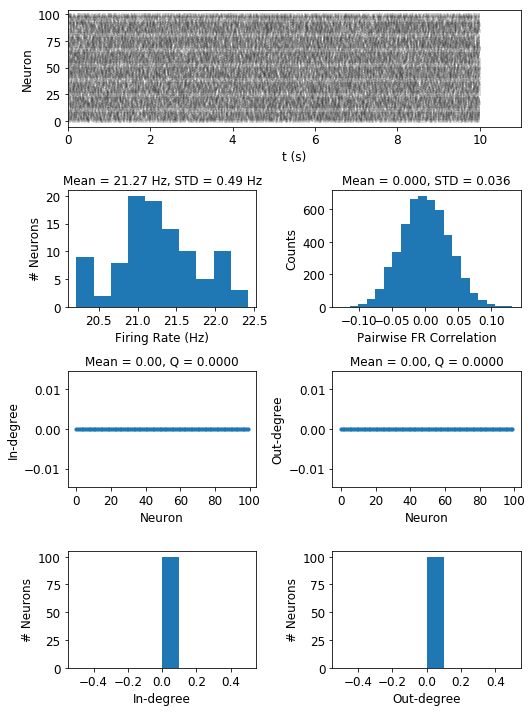

In [14]:
rfcd_plot(unc_ntwk, P_UNC, STORE_UNC)

## Scale-free params

In [15]:
P_SF = Generic(
    # general
    dt=DT,
    
    # ntwk
    n=N,
    gamma=GAMMA,
    t_m=T_M,
    e_l=E_L,
    v_th=V_TH,
    v_reset=V_RESET,
    t_r=T_R,
    e_e=E_E,
    t_e=T_E,
    w_e_rcr=W_E_RCR,  # 0 for no recurrence
    w_e_up=W_E_UP,
    
    # input
    frq_up=FRQ_UP_SF,  # 600 for no recurrence
    stm_off=STM_OFF,
    
    # smln
    dur=DUR,
    seed=SEED)

STORE_SF = GenericFlexible()

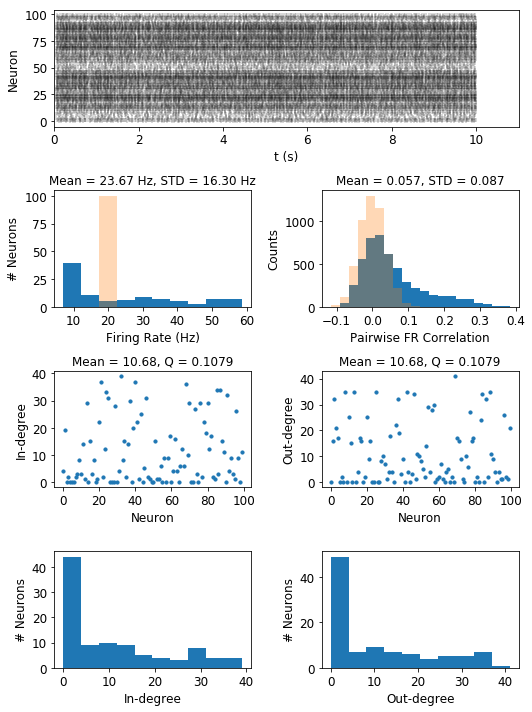

In [16]:
rfcd_plot(sf_ntwk, P_SF, STORE_SF, STORE_UNC=STORE_UNC)

## Erdos-Renyi params

In [17]:
P_ER = Generic(
    # general
    dt=DT,
    
    # ntwk
    n=N,
    q=Q,
    t_m=T_M,
    e_l=E_L,
    v_th=V_TH,
    v_reset=V_RESET,
    t_r=T_R,
    e_e=E_E,
    t_e=T_E,
    w_e_rcr=W_E_RCR,  # 0 for no recurrence
    w_e_up=W_E_UP,
    
    # input
    frq_up=400,  #FRQ_UP_ER,  # 600 for no recurrence
    stm_off=STM_OFF,
    
    # smln
    dur=DUR,
    seed=2)  #SEED)

STORE_ER = GenericFlexible()

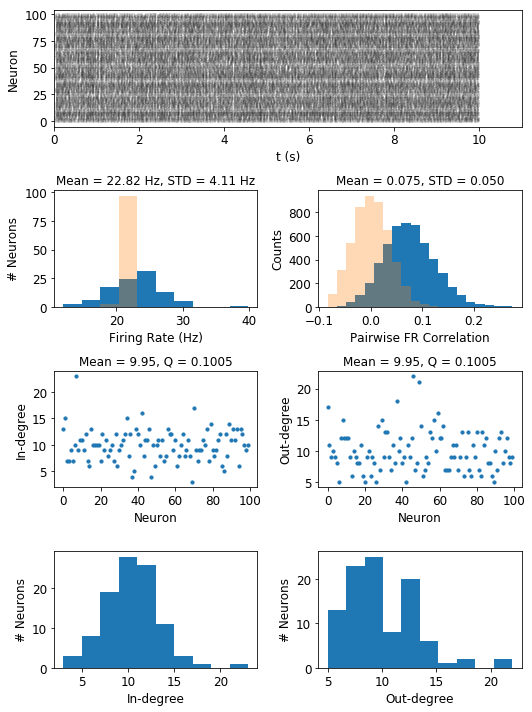

In [18]:
rfcd_plot(er_ntwk, P_ER, STORE_ER, STORE_UNC=STORE_UNC)

## Small-world params

In [19]:
P_SW = Generic(
    # general
    dt=DT,
    
    # ntwk
    n=N,
    k=int(np.round(Q*N)),
    p=0.1,
    t_m=T_M,
    e_l=E_L,
    v_th=V_TH,
    v_reset=V_RESET,
    t_r=T_R,
    e_e=E_E,
    t_e=T_E,
    w_e_rcr=W_E_RCR,  # 0 for no recurrence
    w_e_up=W_E_UP,
    
    # input
    frq_up=400,  # 600 for no recurrence
    stm_off=STM_OFF,
    
    # smln
    dur=DUR,
    seed=SEED)

STORE_SW = GenericFlexible()

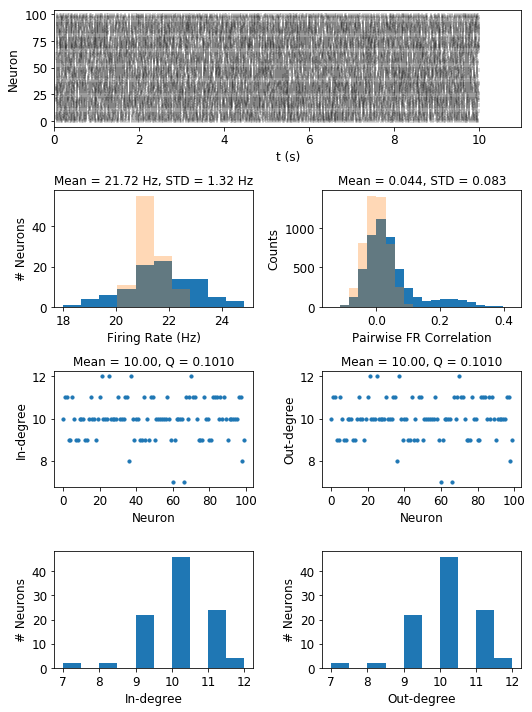

In [20]:
rfcd_plot(sw_ntwk, P_SW, STORE_SW, STORE_UNC=STORE_UNC)

# Excitabilty analysis

In [21]:
from copy import deepcopy


def run_e_leak_change_smlns(make_ntwk, nrns, e_leaks, P, STORE):
    """
    Run identical simulations, except for a set of neurons with
    modified leak potentials.
    """
    
    ntwk_0 = make_ntwk(P, STORE)[0]
    rsp_0 = run(ntwk_0, P, STORE)[0]
    
    rsp_0.ntwk = deepcopy(ntwk_0)
    
    ntwk_1 = deepcopy(ntwk_0)
    ntwk_1.e_l[nrns] = e_leaks
    ntwk_1.v_reset[nrns] = e_leaks
    
    rsp_1 = run(ntwk_1, P, STORE)[0]
    
    rsp_1.ntwk = deepcopy(ntwk_1)
    
    return rsp_0, rsp_1


def get_frs(rsp, P):
    """Get firing rate distribution over cells."""
    
    t_wdw = (T_START, P.stm_off)
    
    t_mask = (t_wdw[0] <= rsp.ts) & (rsp.ts < t_wdw[1])
    spks = rsp.spks[t_mask, :]
    
    fr = spks.sum(0) / (t_wdw[1] - t_wdw[0])
    
    return fr


def dual_raster(ax, rsp_0, rsp_1, nrns_shown=None, nrns_changed=None):
    """Show two overlaid raster plots."""
    
    if nrns_shown is None:
        nrns_shown = range(rsp_0.ntwk.n)
        
    if nrns_changed is None:
        nrns_changed = []
        
    raster(ax, rsp_0.ts, rsp_0.spks, order=nrns_shown, c='b', lw=1, zorder=1)
    raster(ax, rsp_1.ts, rsp_1.spks, order=nrns_shown, c='r', lw=1, zorder=0)
    
    for nrn in nrns_changed:
        if nrn in nrns_shown:
            y = nrns_shown.index(nrn)
            ax.axhline(y, color='gray', alpha=0.4)
    
    return ax


def run_example(make_ntwk, nrns, e_leak, P, STORE):
    """Show raster overlay and firing rate distribution overlay."""
    
    rsp_0, rsp_1 = run_e_leak_change_smlns(make_ntwk, nrns, e_leak, P, STORE)

    gs = gridspec.GridSpec(2, 3)
    fig = plt.figure(figsize=(7.5, 5), tight_layout=True)
    axs = []
    
    axs.append(fig.add_subplot(gs[0, 1:]))

    dual_raster(axs[-1], rsp_0, rsp_1, nrns_changed=nrns)

    axs[-1].set_xlim(0, .2)
    axs[-1].set_xticks([0, 0.05, 0.1, 0.15, 0.2])
    axs[-1].set_facecolor((.95, .95, .95))
    
    axs.append(fig.add_subplot(gs[1, :]))

    nrns = range(rsp_0.ntwk.n)

    axs[-1].bar(nrns, get_frs(rsp_1, P) - get_frs(rsp_0, P), color='k', align='center')

    axs[-1].set_ylim(-5, 60)
    
    axs[-1].set_xlabel('Neuron')
    axs[-1].set_ylabel('∆ firing rate (Hz)')
    
    axs.append(axs[-1].twinx())
    
    axs[-1].bar(nrns, get_frs(rsp_0, P), color='g', alpha=0.3, align='center')
    
    axs[-1].set_ylim(-5, 60)
    
    axs[-1].set_ylabel('Initial firing rate (Hz)', color='g')
    
    for ax in axs:
        set_font_size(ax, 12)
    
    return fig, axs

## Scale-free examples

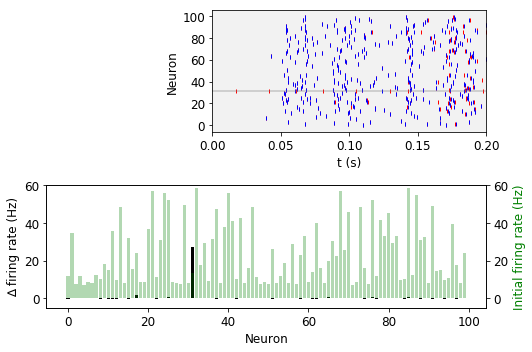

In [22]:
run_example(sf_ntwk, [31], E_L_1, P_SF, STORE=GenericFlexible());

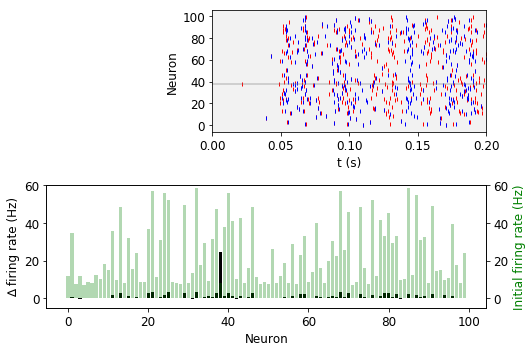

In [23]:
run_example(sf_ntwk, [38], E_L_1, P_SF, STORE=GenericFlexible());

## Erdos-Renyi examples

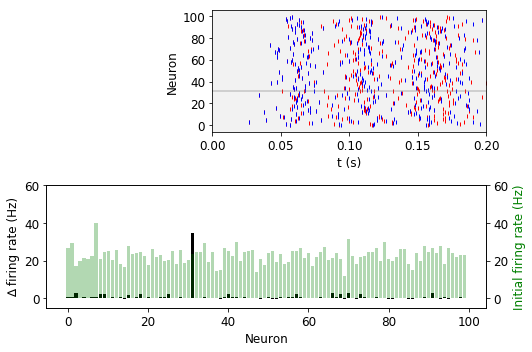

In [24]:
run_example(er_ntwk, [31], E_L_1, P_ER, STORE=GenericFlexible());

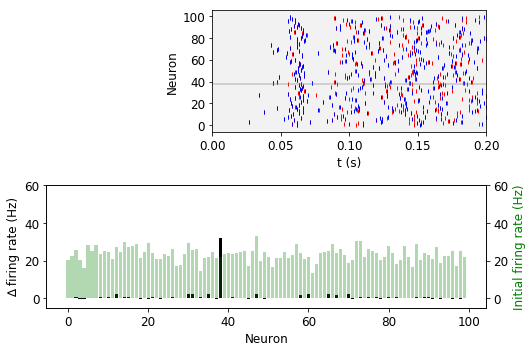

In [25]:
run_example(er_ntwk, [38], E_L_1, P_ER, STORE=GenericFlexible());

## Small-world examples

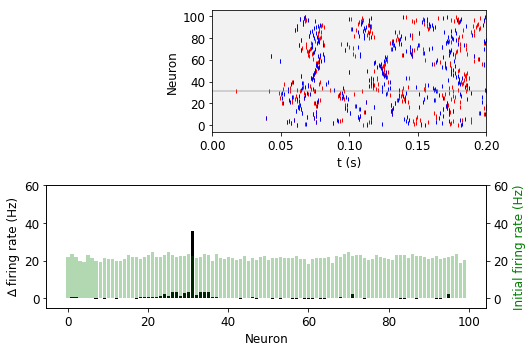

In [26]:
run_example(sw_ntwk, [31], E_L_1, P_SW, STORE=GenericFlexible());

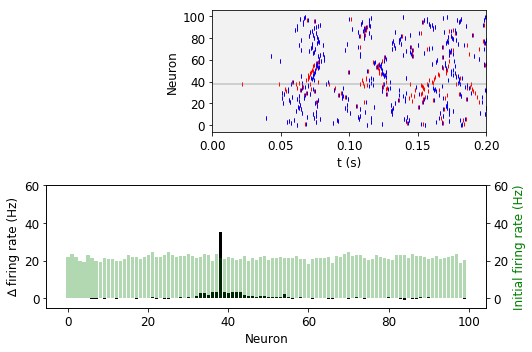

In [27]:
run_example(sw_ntwk, [38], E_L_1, P_SW, STORE=GenericFlexible());

# Excitability influence distributions

In [28]:
import sys
from scipy import stats


def calc_xblt_ifl(make_ntwk, P):
    """Calculate excitability influence, in-degree, and out-degree across neurons."""
    
    # loop over all neurons in network
    in_deg = []
    out_deg = []
    xblt_ifl = []

    for nrn in range(P.n):

        if nrn % 10 == 0:
            sys.stdout.write('|')
        else:
            sys.stdout.write('.')

        STORE = GenericFlexible()
        
        rsp_0, rsp_1 = run_e_leak_change_smlns(make_ntwk, [nrn], E_L_1, P, STORE)

        # a few checks
        ## both ntwks have equal weight matrices
        assert(np.all(rsp_0.ntwk.ws_rcr['E'] == rsp_1.ntwk.ws_rcr['E'].todense()))

        ## in & out-degree match weight matrix calc
        assert((rsp_0.ntwk.ws_rcr['E'][nrn, :] > 0).sum() == STORE.g.in_degree(nrn))
        assert((rsp_0.ntwk.ws_rcr['E'][:, nrn] > 0).sum() == STORE.g.out_degree(nrn))

        # store in- & out-degree
        in_deg.append(STORE.g.in_degree(nrn))
        out_deg.append(STORE.g.out_degree(nrn))

        # calc & store excitability influence
        fr_0 = get_frs(rsp_0, P)
        fr_1 = get_frs(rsp_1, P)

        # mask out neuron whose excitability was changed
        fr_0[nrn] = np.nan
        fr_1[nrn] = np.nan

        xblt_ifl.append(np.sqrt(np.nansum((fr_0 - fr_1)**2) / P.n))
        
    return xblt_ifl, in_deg, out_deg
    

def plot_xblt_ifl_vs_deg(xblt_ifl, in_deg, out_deg):
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(7.5, 5), tight_layout=True)
    axs = []
    
    axs.append(fig.add_subplot(gs[0, 0]))

    axs[-1].scatter(in_deg, xblt_ifl, s=10)

    r, p = stats.pearsonr(in_deg, xblt_ifl)
    slp, icpt = stats.linregress(in_deg, xblt_ifl)[:2]

    x = np.array([np.nanmin(in_deg), np.nanmax(in_deg)])
    y = slp*x + icpt

    axs[-1].plot(x, y, c='r')

    axs[-1].set_xlabel('In-deg')
    axs[-1].set_ylabel('Exc. Ifl. (Hz)')
    axs[-1].set_title('R = {0:.3f}, P = {1:.3f}'.format(r, p))

    axs.append(fig.add_subplot(gs[0, 1]))
    
    axs[-1].scatter(out_deg, xblt_ifl, s=10)

    r, p = stats.pearsonr(out_deg, xblt_ifl)
    slp, icpt = stats.linregress(out_deg, xblt_ifl)[:2]

    x = np.array([np.nanmin(out_deg), np.nanmax(out_deg)])
    y = slp*x + icpt

    axs[-1].plot(x, y, c='r')

    axs[-1].set_xlabel('Out-deg')
    axs[-1].set_ylabel('Exc. Ifl. (Hz)')
    axs[-1].set_title('R = {0:.3f}, P = {1:.3f}'.format(r, p))

    axs.append(fig.add_subplot(gs[1, 0]))
    
    axs[-1].scatter(
        in_deg, out_deg, c=xblt_ifl, s=10, 
        vmin=np.nanmin(xblt_ifl), vmax=np.nanmax(xblt_ifl))

    axs[-1].set_xlabel('In-deg')
    axs[-1].set_ylabel('Out-deg')
    axs[-1].set_facecolor((.9, .9, .9))

    for ax in axs:
        set_font_size(ax, 12)

# Comparing excitability influence distributions across network structures

In [29]:
xblt_ifls = {}

## Scale-free

In [30]:
xblt_ifl_sf, in_deg_sf, out_deg_sf = calc_xblt_ifl(sf_ntwk, P_SF)

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........

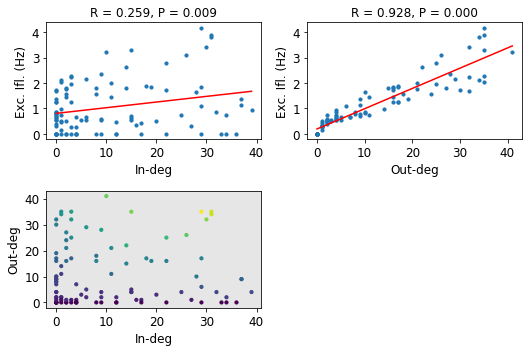

In [31]:
plot_xblt_ifl_vs_deg(xblt_ifl_sf, in_deg_sf, out_deg_sf)
xblt_ifls['sf'] = deepcopy(xblt_ifl_sf)

## Erdos-Renyi

In [32]:
xblt_ifl_er, in_deg_er, out_deg_er = calc_xblt_ifl(er_ntwk, P_ER)

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........

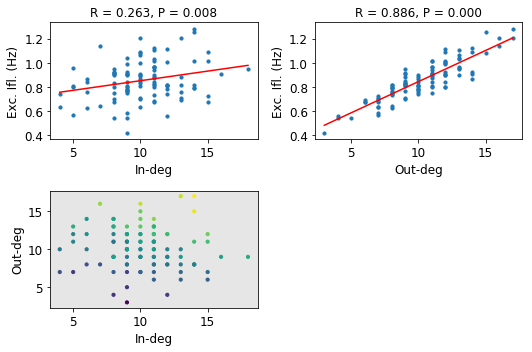

In [33]:
plot_xblt_ifl_vs_deg(xblt_ifl_er, in_deg_er, out_deg_er)
xblt_ifls['er'] = deepcopy(xblt_ifl_er)

## Small-world

In [34]:
xblt_ifl_sw, in_deg_sw, out_deg_sw = calc_xblt_ifl(sw_ntwk, P_SW)

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........

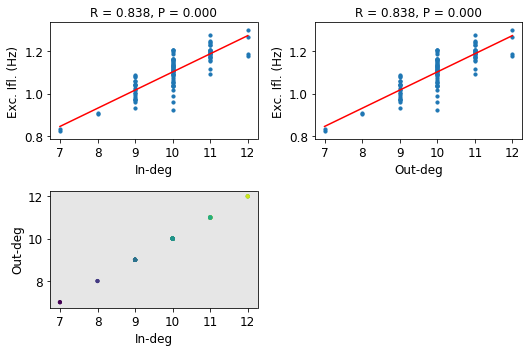

In [35]:
plot_xblt_ifl_vs_deg(xblt_ifl_sw, in_deg_sw, out_deg_sw)
xblt_ifls['sw'] = deepcopy(xblt_ifl_sw)

## Compare excitability influence distributions

SF: mu = 1.04, std = 1.01
ER: mu = 0.85, std = 0.16
SW: mu = 1.10, std = 0.10


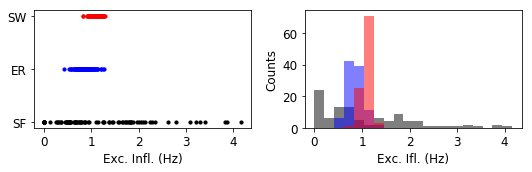

In [36]:
colors = {'sf': 'k', 'er': 'b', 'sw': 'r'}
fig, axs = plt.subplots(1, 2, figsize=(7.5, 7.5/3), tight_layout=True)

axs[0].scatter(xblt_ifls['sf'], np.repeat(0, P_SF.n), c=colors['sf'], s=10)
axs[0].scatter(xblt_ifls['er'], np.repeat(1, P_ER.n), c=colors['er'], s=10)
axs[0].scatter(xblt_ifls['sw'], np.repeat(2, P_ER.n), c=colors['sw'], s=10)

axs[0].set_xlabel('Exc. Infl. (Hz)')
axs[0].set_yticks([0, 1, 2])
axs[0].set_yticklabels(['SF', 'ER', 'SW'])

bins = np.histogram(xblt_ifls['sf'], bins=20)[1]

axs[1].hist(xblt_ifls['sf'], bins, color=colors['sf'], alpha=0.5)
axs[1].hist(xblt_ifls['er'], bins, color=colors['er'], alpha=0.5)
axs[1].hist(xblt_ifls['sw'], bins, color=colors['sw'], alpha=0.5)

axs[1].set_xlabel('Exc. Ifl. (Hz)')
axs[1].set_ylabel('Counts')

for ax in axs:
    set_font_size(ax, 12)
    
print('SF: mu = {0:.2f}, std = {1:.2f}'.format(
    np.mean(xblt_ifls['sf']),
    np.std(xblt_ifls['sf'])))
    
print('ER: mu = {0:.2f}, std = {1:.2f}'.format(
    np.mean(xblt_ifls['er']),
    np.std(xblt_ifls['er'])))
      
print('SW: mu = {0:.2f}, std = {1:.2f}'.format(
    np.mean(xblt_ifls['sw']),
    np.std(xblt_ifls['sw'])))

# Re-run for multiple random seeds

In [37]:
N_TRIALS = 50

np.random.seed(SEED)

xblt_ifl_means = {'sf': [], 'er': [], 'sw': []}
xblt_ifl_stds = {'sf': [], 'er': [], 'sw': []}

for ctr in range(N_TRIALS):
    print('Trial {}'.format(ctr + 1))
    
    seed = np.random.randint(0, 10000000)
    
    P_SF.__dict__['seed'] = seed
    P_ER.__dict__['seed'] = seed
    P_SW.__dict__['seed'] = seed
    
    xblt_ifl_sf = calc_xblt_ifl(sf_ntwk, P_SF)[0]
    print('')
    xblt_ifl_er = calc_xblt_ifl(er_ntwk, P_ER)[0]
    print('')
    xblt_ifl_sw = calc_xblt_ifl(sw_ntwk, P_SW)[0]
    
    xblt_ifl_means['sf'].append(np.mean(xblt_ifl_sf))
    xblt_ifl_stds['sf'].append(np.std(xblt_ifl_sf))
    
    xblt_ifl_means['er'].append(np.mean(xblt_ifl_er))
    xblt_ifl_stds['er'].append(np.std(xblt_ifl_er))
    
    xblt_ifl_means['sw'].append(np.mean(xblt_ifl_sw))
    xblt_ifl_stds['sw'].append(np.std(xblt_ifl_sw))
    print('')

Trial 1
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 2
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 3
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........
Trial 4
|.........|.........|.........|.........|.........|........

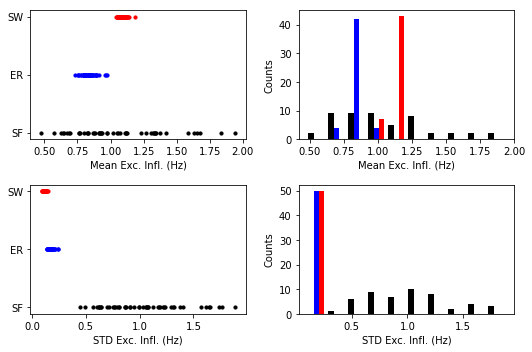

In [38]:
colors = {'sf': 'k', 'er': 'b', 'sw': 'r'}
fig, axs = plt.subplots(2, 2, figsize=(7.5, 5), tight_layout=True)

# means
axs[0, 0].scatter(xblt_ifl_means['sf'], np.repeat(0, N_TRIALS), s=10, c=colors['sf'])
axs[0, 0].scatter(xblt_ifl_means['er'], np.repeat(1, N_TRIALS), s=10, c=colors['er'])
axs[0, 0].scatter(xblt_ifl_means['sw'], np.repeat(2, N_TRIALS), s=10, c=colors['sw'])

axs[0, 0].set_xlabel('Mean Exc. Infl. (Hz)')
axs[0, 0].set_yticks([0, 1, 2])
axs[0, 0].set_yticklabels(['SF', 'ER', 'SW'])

axs[0, 1].hist(
    np.array([xblt_ifl_means[k] for k in ['sf', 'er', 'sw']]).T,
    color=[colors[k] for k in ['sf', 'er', 'sw']])

axs[0, 1].set_xlabel('Mean Exc. Infl. (Hz)')
axs[0, 1].set_ylabel('Counts')

# stds
axs[1, 0].scatter(xblt_ifl_stds['sf'], np.repeat(0, N_TRIALS), s=10, c=colors['sf'])
axs[1, 0].scatter(xblt_ifl_stds['er'], np.repeat(1, N_TRIALS), s=10, c=colors['er'])
axs[1, 0].scatter(xblt_ifl_stds['sw'], np.repeat(2, N_TRIALS), s=10, c=colors['sw'])

axs[1, 0].set_xlabel('STD Exc. Infl. (Hz)')
axs[1, 0].set_yticks([0, 1, 2])
axs[1, 0].set_yticklabels(['SF', 'ER', 'SW'])

axs[1, 1].hist(
    np.array([xblt_ifl_stds[k] for k in ['sf', 'er', 'sw']]).T,
    color=[colors[k] for k in ['sf', 'er', 'sw']])

axs[1, 1].set_xlabel('STD Exc. Infl. (Hz)')
axs[1, 1].set_ylabel('Counts');

## Calculate stats

In [42]:
# mean mean & std
print('Mean SF mean = {0:.5f}'.format(np.mean(xblt_ifl_means['sf'])))
print('Mean SF std = {0:.5f}'.format(np.mean(xblt_ifl_stds['sf'])))

print('Mean ER mean = {0:.5f}'.format(np.mean(xblt_ifl_means['er'])))
print('Mean ER std = {0:.5f}'.format(np.mean(xblt_ifl_stds['er'])))

print('Mean SW mean = {0:.5f}'.format(np.mean(xblt_ifl_means['sw'])))
print('Mean SW std = {0:.5f}'.format(np.mean(xblt_ifl_stds['sw'])))

# p-values (t-test)
for a, b in [('sf', 'er'), ('sf', 'sw'), ('er', 'sw')]:
    
    p_mu = stats.ttest_ind(xblt_ifl_means[a], xblt_ifl_means[b])[1]
    p_std = stats.ttest_ind(xblt_ifl_stds[a], xblt_ifl_stds[b])[1]
    
    print('P_MU({0}, {1}) = {2:.5f}'.format(a.upper(), b.upper(), p_mu))
    print('P_STD({0}, {1}) = {2:.5f}'.format(a.upper(), b.upper(), p_std))

Mean SF mean = 1.05853
Mean SF std = 1.04068
Mean ER mean = 0.83494
Mean ER std = 0.17500
Mean SW mean = 1.09001
Mean SW std = 0.11555
P_MU(SF, ER) = 0.00001
P_STD(SF, ER) = 0.00000
P_MU(SF, SW) = 0.51807
P_STD(SF, SW) = 0.00000
P_MU(ER, SW) = 0.00000
P_STD(ER, SW) = 0.00000
